# Comparing FaceNet and Eigenfaces on lfw data and your own data

Preparation:

- Download a pretrained tensorflow model of facenet from here:https://github.com/davidsandberg/facenet/
- Download the lfw data from here: http://vis-www.cs.umass.edu/lfw/

In [1]:
import numpy as np
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import utils

import os
from os.path import join as pjoin
import sys
import copy

import models.nn4 as network

In [2]:
tf.reset_default_graph()
sess = tf.Session()
saver = tf.train.import_meta_graph('model-20180402-114759.meta')
saver.restore(sess, './model-20180402-114759.ckpt-275')
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

W0718 13:30:53.204780 140570006840960 deprecation.py:323] From /home/dennis/envs/ml-new/lib/python3.7/site-packages/tensorflow/python/training/queue_runner_impl.py:391: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0718 13:30:53.260755 140570006840960 deprecation.py:323] From /home/dennis/envs/ml-new/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [3]:
def load_data(data_dir, take_all = False):
    data = {}
    orig_data = {}
    pics_ctr = 0
    for guy in os.listdir(data_dir):
        person_dir = pjoin(data_dir, guy)
        curr_pics = [cv2.imread(pjoin(person_dir, f)) for f in os.listdir(person_dir)]
        curr_pics_processed = [utils.preproc(pic) for pic in curr_pics]
        if (not take_all) and (len(curr_pics) < 2 or np.random.random() > 0.7):
            continue
        if not take_all and pics_ctr > 500:
            break
        
        orig_data[guy] = curr_pics
        data[guy] = curr_pics_processed
        pics_ctr += len(curr_pics)

    return data, pics_ctr, orig_data

Loaded 832 pics.
Random guy from LFW dataset


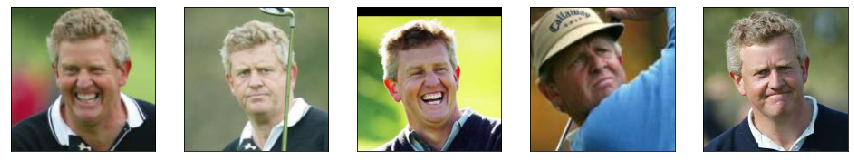

In [4]:
DATA_DIR = '../data/lfw'
data, n_pics, orig_data = load_data(DATA_DIR)

print('Loaded %d pics.' % n_pics)

# load random guy and show his pics
random_guy = np.random.choice(list(data.keys()))
    
fig = plt.figure()
print('Random guy from LFW dataset')
fig.set_figheight(15)
fig.set_figwidth(15)
for i, pic in enumerate(data[random_guy]):
    utils.imshow(fig, pic, 1, len(data[random_guy]), i+1)

In [5]:
#initialize embeddings dict
emb_dict = {}
for guy in data:
    emb_dict[guy] = list(sess.run([embeddings], feed_dict={images_placeholder: np.array(data[guy]), phase_train_placeholder: False })[0])

### test the model

We sample the pic from Bob_Graham.
---------------------------
I think, the pic belongs to Bob_Graham.


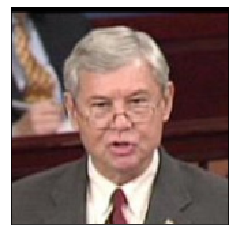

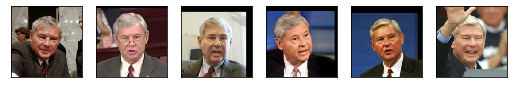

In [6]:
testing_data = copy.deepcopy(data)
testing_emb = copy.deepcopy(emb_dict)

# take random guy to test
guy = np.random.choice(list(testing_data.keys()))

# take random pic of the guy and remove taken pic from the data to avoid cheating
p_ind = np.random.randint(len(testing_data[guy]))
curr_pic = testing_data[guy].pop(p_ind)
curr_emb = emb_dict[guy].pop(p_ind)


#compute mean distance from random pic of the chosen guy to all the guys in the database
min_dist = sys.maxsize

mean_dist = []
for g in testing_data.keys():
    mean_embedding = np.mean(emb_dict[g], axis=0)
    
    # compute dist from guy's pic to mean embedding
    dist = np.linalg.norm(mean_embedding - curr_emb)
    mean_dist.append(dist)
    if min_dist > dist:
        min_dist = dist
        closest_guy = g
    #print('%s\t: %.2f' % (g,dist))

fig1 = plt.figure()
print('We sample the pic from %s.' % guy)
print('---------------------------')
print("I think, the pic belongs to %s." % closest_guy)

utils.imshow(fig1, curr_pic)
fig2 = plt.figure()
fig2.set_figheight(15)
fig2.set_figwidth(15)
# show no more than 10 pics of the guy
n_p = max(len(data[closest_guy]), 10) 
for i, pic in enumerate(data[closest_guy]):
    if i > n_p:
        break
    utils.imshow(fig2, pic, 1, n_p, i+1) 

### t-SNE for 2D representation of embeddings

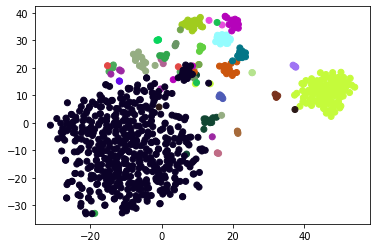

In [7]:
from sklearn.manifold import TSNE
arr = []
cols = []

for guy in emb_dict:
    color = utils.get_random_color()
    for p in emb_dict[guy]:
        arr.append(p)
        cols.append(color)        

model = TSNE(n_components=2, random_state=0, init='pca')
np.set_printoptions(suppress=True)
tsne_res = model.fit_transform(arr) 
plt.scatter(tsne_res[:,0], tsne_res[:,1], color=cols);

# Try it with your own image

Loaded 7 pics.
Random guy from own dataset


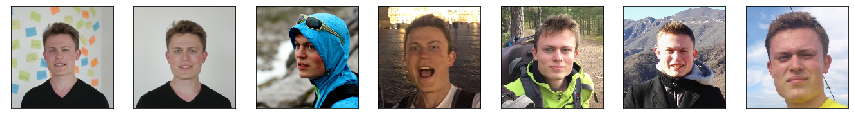

In [8]:
OWN_DATA_DIR = '../data/own'
own_data, own_n_pics, orig_own_data = load_data(OWN_DATA_DIR, take_all=True)

print('Loaded %d pics.' % own_n_pics)

# load random guy and show his pics
random_guy = np.random.choice(list(own_data.keys()))
    
fig = plt.figure()
print('Random guy from own dataset')
fig.set_figheight(15)
fig.set_figwidth(15)
for i, pic in enumerate(own_data[random_guy]):
    utils.imshow(fig, pic, 1, len(own_data[random_guy]), i+1)

In [9]:
# add the data to the embedding dict
for guy in own_data:
    data[guy] = own_data[guy]
    orig_data[guy] = orig_own_data[guy]
    emb_dict[guy] = list(sess.run([embeddings], feed_dict={images_placeholder: np.array(own_data[guy]), phase_train_placeholder: False })[0])

George_HW_Bush
1.2360494
Marc_Grossman
1.4711367
Michael_Schumacher
1.1254
John_Manley
1.1825652
Darren_Clarke
1.0434859
Larry_Ellison
1.4427204
Tiger_Woods
1.1066701
Colin_Montgomerie
1.2114457
Arminio_Fraga
1.3721162
Heath_Ledger
1.048957
Mike_Tyson
1.319185
Edward_James_Olmos
1.3930053
Gerhard_Schroeder
1.3265214
Will_Smith
1.2387877
Felipe_Perez_Roque
1.2738836
Igor_Ivanov
1.1683332
Juan_Ignacio_Chela
1.1781846
John_Howard
1.2178147
Richard_Shelby
1.0767633
Bob_Graham
1.3043429
Tommy_Haas
1.1168857
Jane_Fonda
1.1628658
Pervez_Musharraf
1.2214625
Robert_Fico
1.1725501
Guido_Westerwelle
1.3704151
David_Caruso
1.2717441
Edmund_Stoiber
1.3510357
George_W_Bush
1.2805039
Dennis
0.885482
I think, the pic belongs to Dennis.


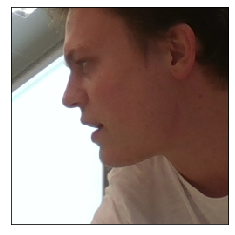

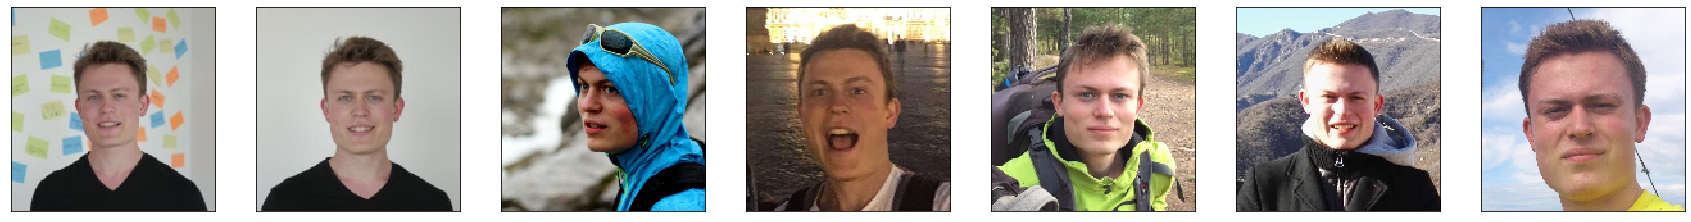

In [63]:
vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    
vc.release()
w,h = 250, 250
y = int((frame.shape[0] - 250) / 2)
x = int((frame.shape[1] - 250) / 2)

crop_img = frame[y:y+h, x:x+w]
curr_pic = [ utils.preproc(crop_img) ]
curr_emb = list(sess.run([embeddings], feed_dict={images_placeholder: np.array(curr_pic), phase_train_placeholder: False })[0])


#compute mean distance from random pic of the chosen guy to all the guys in the database
min_dist = sys.maxsize

mean_dist = []
for g in emb_dict.keys():
    print(g)
    mean_embedding = np.mean(emb_dict[g], axis=0)
    #for p in emb_dict[g]:
    # compute dist from guy's pic to mean embedding
    dist = np.linalg.norm(mean_embedding - curr_emb)
    # dist = np.linalg.norm(p - curr_emb)
    mean_dist.append(dist)
    print(dist)
    if min_dist > dist:
        min_dist = dist
        closest_guy = g
    #print('%s\t: %.2f' % (g,dist))

fig1 = plt.figure()
print("I think, the pic belongs to %s." % closest_guy)

utils.imshow(fig1, crop_img)
fig2 = plt.figure()
fig2.set_figheight(30)
fig2.set_figwidth(30)
# show no more than 5 pics of the guy
n_p = max(len(data[closest_guy]), 5) 
for i, pic in enumerate(data[closest_guy]):
    if i > n_p:
        break
    utils.imshow(fig2, pic, 1, n_p, i+1) 

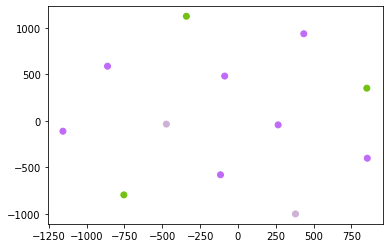

In [64]:
from sklearn.manifold import TSNE
arr = []
cols = []


for guy in ["Dennis", "Darren_Clarke", "Juan_Ignacio_Chela"]:
    color = utils.get_random_color()
    for p in emb_dict[guy]:
        arr.append(p)
        cols.append(color)        

model = TSNE(n_components=2, random_state=0, init='pca')
np.set_printoptions(suppress=True)
tsne_res = model.fit_transform(arr) 
plt.scatter(tsne_res[:,0], tsne_res[:,1], color=cols);

# Trying out classical approaches

## First step: face alignment

In [12]:
import face_alignment

In [13]:
def align_face(img):
    return face_alignment.face_alignment(img, scale=0.9, face_size=(250,250))

def try_out_face_alignement(img):
    aligned = align_face(img)

    fig_al = plt.figure()

    ax1 = fig_al.add_subplot(1, 2, 1)
    ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
    ax2 = fig_al.add_subplot(1, 2, 2)
    ax2.imshow(cv2.cvtColor(aligned[0],cv2.COLOR_BGR2RGB));

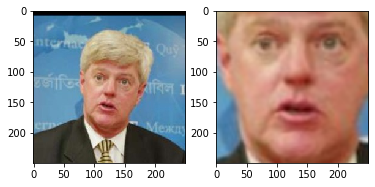

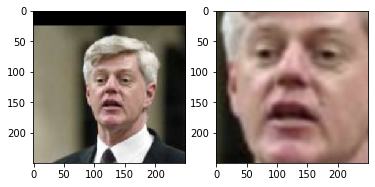

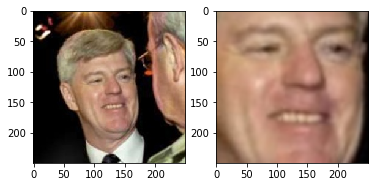

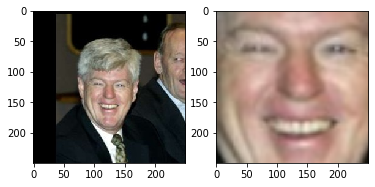

In [14]:
random_person = np.random.choice(list(orig_data.keys()))
counter = 0
for img in orig_data[random_person]:
    try_out_face_alignement(img)
    counter+=1
    if counter > 3:
        break

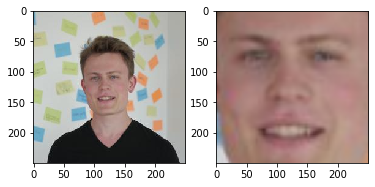

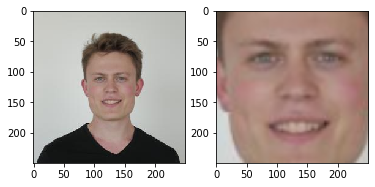

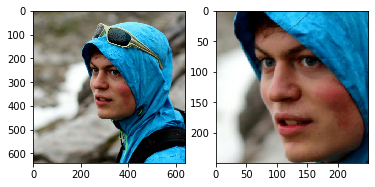

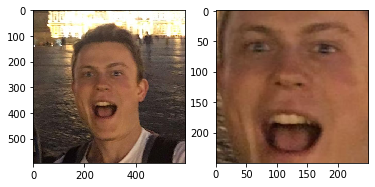

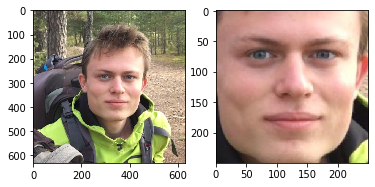

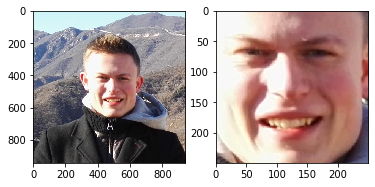

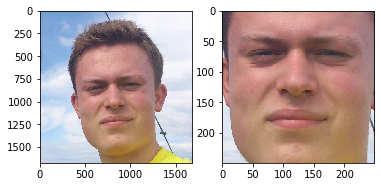

In [15]:
for img in orig_data['Dennis']:
    try_out_face_alignement(img)

In [16]:
# align all faces now
aligned_data = {}

for key in orig_data:
    aligned_data[key] = []
    print(f'Aligning {key}')
    for img in orig_data[key]:
        aligned_data[key].append(align_face(img))

Aligning George_HW_Bush
Aligning Marc_Grossman
Aligning Michael_Schumacher
Aligning John_Manley
Aligning Darren_Clarke
Aligning Larry_Ellison
Aligning Tiger_Woods
Aligning Colin_Montgomerie
Aligning Arminio_Fraga
Aligning Heath_Ledger
Aligning Mike_Tyson
Aligning Edward_James_Olmos
Aligning Gerhard_Schroeder
Aligning Will_Smith
Aligning Felipe_Perez_Roque
Aligning Igor_Ivanov
Aligning Juan_Ignacio_Chela
Aligning John_Howard
Aligning Richard_Shelby
Aligning Bob_Graham
Aligning Tommy_Haas
Aligning Jane_Fonda
Aligning Pervez_Musharraf
Aligning Robert_Fico
Aligning Guido_Westerwelle
Aligning David_Caruso
Aligning Edmund_Stoiber
Aligning George_W_Bush
Aligning Dennis


# Grayscale conversion

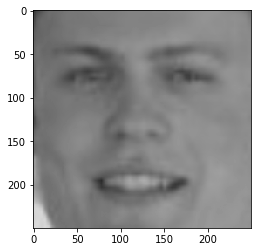

In [17]:
def rgb2gray(rgb):
    return np.dot(rgb[0][...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(aligned_data['Dennis'][0])
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

In [18]:
# gray convert all images now
aligned_data_gray = {}

for key in aligned_data:
    aligned_data_gray[key] = []
    print(f'Gray conversion {key}')
    for img in aligned_data[key]:
        if (img):
            aligned_data_gray[key].append(rgb2gray(img))

Gray conversion George_HW_Bush
Gray conversion Marc_Grossman
Gray conversion Michael_Schumacher
Gray conversion John_Manley
Gray conversion Darren_Clarke
Gray conversion Larry_Ellison
Gray conversion Tiger_Woods
Gray conversion Colin_Montgomerie
Gray conversion Arminio_Fraga
Gray conversion Heath_Ledger
Gray conversion Mike_Tyson
Gray conversion Edward_James_Olmos
Gray conversion Gerhard_Schroeder
Gray conversion Will_Smith
Gray conversion Felipe_Perez_Roque
Gray conversion Igor_Ivanov
Gray conversion Juan_Ignacio_Chela
Gray conversion John_Howard
Gray conversion Richard_Shelby
Gray conversion Bob_Graham
Gray conversion Tommy_Haas
Gray conversion Jane_Fonda
Gray conversion Pervez_Musharraf
Gray conversion Robert_Fico
Gray conversion Guido_Westerwelle
Gray conversion David_Caruso
Gray conversion Edmund_Stoiber
Gray conversion George_W_Bush
Gray conversion Dennis


# PCA

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time

X = []
Y = []

for key in aligned_data_gray:
    for img in aligned_data_gray[key]:
        X.append(img)
        Y.append(key)

X = np.array(X)
print(X.shape)
X = X.reshape(X.shape[0],-1)
X.shape

(830, 250, 250)


(830, 62500)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 747 faces
done in 8.011s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.659s


In [21]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/home/dennis/envs/ml-new/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


done in 60.441s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [22]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))

Predicting people's names on the test set
done in 0.017s
                    precision    recall  f1-score   support

     Arminio_Fraga       1.00      1.00      1.00         1
        Bob_Graham       0.00      0.00      0.00         2
            Dennis       0.00      0.00      0.00         2
    Edmund_Stoiber       0.00      0.00      0.00         1
    George_HW_Bush       0.00      0.00      0.00         0
     George_W_Bush       0.77      0.98      0.86        51
 Gerhard_Schroeder       0.31      0.80      0.44         5
       Igor_Ivanov       0.00      0.00      0.00         4
        Jane_Fonda       0.00      0.00      0.00         1
       John_Howard       0.00      0.00      0.00         2
       John_Manley       0.00      0.00      0.00         1
Michael_Schumacher       0.00      0.00      0.00         4
        Mike_Tyson       0.00      0.00      0.00         1
  Pervez_Musharraf       1.00      0.50      0.67         2
       Tiger_Woods       1.00      0.20   

/home/dennis/envs/ml-new/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dennis/envs/ml-new/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


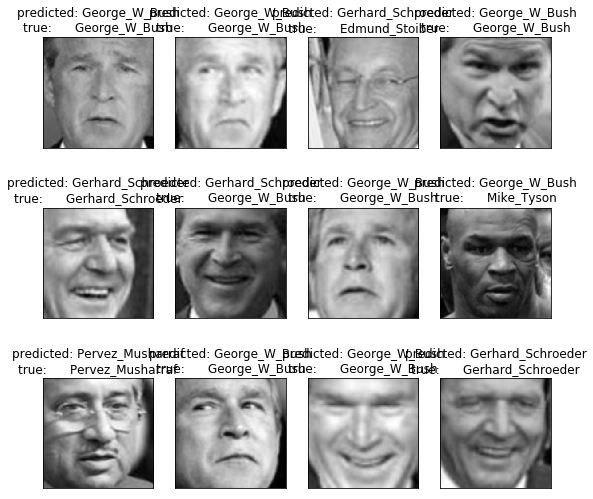

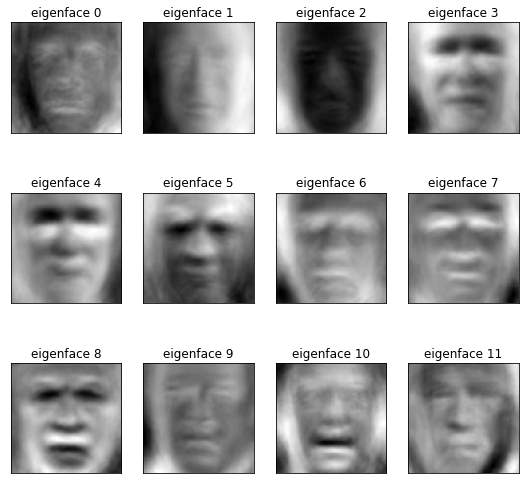

In [23]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, i):
    pred_name = y_pred[i]
    true_name = y_test[i]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# Comparing the results with FaceNet

In [28]:
def classify_facenet(img):
    curr_pic = [ utils.preproc(crop_img) ]
    curr_emb = list(sess.run([embeddings], feed_dict={images_placeholder: np.array(curr_pic), phase_train_placeholder: False })[0])
    min_dist = sys.maxsize

    mean_dist = []
    for g in testing_data.keys():
        mean_embedding = np.mean(emb_dict[g], axis=0)

        # compute dist from guy's pic to mean embedding
        dist = np.linalg.norm(mean_embedding - curr_emb)
        mean_dist.append(dist)
        if min_dist > dist:
            min_dist = dist
            closest_guy = g
        #print('%s\t: %.2f' % (g,dist))

    return closest_guy

In [34]:
classify_facenet(X_test[30])

'Darren_Clarke'

In [36]:
y_test[30]

'George_W_Bush'

Okay - let's build new sets then...

In [54]:
X_new = []
Y_new = []

for key in emb_dict:
    for emb in emb_dict[key]:
        X_new.append(emb)
        Y_new.append(key)
        
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, Y_new, test_size=0.1, random_state=42)

In [55]:
def classify_facenet_new(curr_emb):
    min_dist = sys.maxsize

    mean_dist = []
    for i, emb in enumerate(X_train_new):
        # compute dist from guy's pic to mean embedding
        dist = np.linalg.norm(emb - curr_emb)
        mean_dist.append(dist)
        if min_dist > dist:
            min_dist = dist
            closest_guy = y_train_new[i]
        #print('%s\t: %.2f' % (g,dist))

    return closest_guy

In [56]:
classify_facenet_new(X_test_new[3])

'Tiger_Woods'

In [57]:
y_test_new[3]

'Tiger_Woods'

In [61]:
y_pred_new = [classify_facenet_new(emb) for emb in X_test_new]

print(classification_report(y_test_new, y_pred_new))

                    precision    recall  f1-score   support

     Arminio_Fraga       1.00      1.00      1.00         1
        Bob_Graham       1.00      1.00      1.00         1
            Dennis       0.00      0.00      0.00         2
    Edmund_Stoiber       1.00      1.00      1.00         3
     George_W_Bush       1.00      0.98      0.99        51
 Gerhard_Schroeder       1.00      1.00      1.00         7
       Igor_Ivanov       1.00      1.00      1.00         5
       John_Howard       0.50      1.00      0.67         1
       John_Manley       1.00      1.00      1.00         1
Juan_Ignacio_Chela       0.00      0.00      0.00         0
Michael_Schumacher       0.75      0.75      0.75         4
        Mike_Tyson       1.00      1.00      1.00         1
  Pervez_Musharraf       0.50      1.00      0.67         1
       Tiger_Woods       1.00      0.80      0.89         5
        Tommy_Haas       1.00      1.00      1.00         1
        Will_Smith       0.00      0.00